In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Память:        3,8G        2,5G        173M        619M        1,1G        381M
Подкачка:        3,9G        1,9G        2,0G


In [2]:
!nvidia-smi

Wed May 23 13:14:16 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00007156:00:00.0 Off |                    0 |
| N/A   45C    P0   134W / 250W |   6122MiB / 16276MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00008E4F:00:00.0 Off |                    0 |
| N/A   36C    P0    61W / 250W |  11781MiB / 16276MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import numpy as np
import pandas as pd
from scipy import ndimage as nd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import time
import os
import nibabel as nib
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output
import copy

%pylab inline

/home/service/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/service/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

('Torch version:', '0.4.0')
Using GPU


In [5]:
cuda_n = 0

In [6]:
PathConn = "WC0/WC0/"
mri_files = sorted([fileList for dirName, subdirList, fileList in os.walk(PathConn) if fileList][0])
mri_files = list(map(lambda x: PathConn + x, mri_files))

In [7]:
len(mri_files)

90

In [8]:
mri_files[0].split("-")[0][-3:]

'001'

In [9]:
def get_patient_number(patient_file):
    return "P" + patient_file.split("-")[0][-3:]

In [10]:
labels = pd.read_csv("targets 28.02.2018.csv", sep=";")

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "Positive", "Negative", "TLEPositive", "TLENegative", "NoTLE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
# E_C_idx = labels["E/C"].notnull()
# D_C_idx = labels["D/C"].notnull()
# DE_E_idx = labels["DE/E"].notnull()
labels = labels.reset_index(drop=True)
labels.tail()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
95,P100,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
96,P105,3,2,1,NaN,6.0,6.0,NaN,3.0,7,9.0,NaN,NaN
97,P106,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
98,P107,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
99,P108,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0


In [11]:
labels = labels[labels.patient_number.isin(list(map(get_patient_number, mri_files)))]
labels = labels.reset_index(drop=True)
labels.tail()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
85,P100,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
86,P105,3,2,1,NaN,6.0,6.0,NaN,3.0,7,9.0,NaN,NaN
87,P106,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
88,P107,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
89,P108,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0


In [12]:
labels.shape

(90, 13)

In [13]:
problem = "E/no E"
problem_label = "E"
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)
label.head()

0    1
1    1
2    1
3    0
4    1
Name: E/no E, dtype: int64

In [14]:
# IMG_SHAPE = (-1, 1, 90, 108, 90)
# IMG_SHAPE = (-1, 1, 52, 62, 52)
IMG_SHAPE = (-1, 1, 180, 216, 180)

# нужно применять сразу ко всему батчу изображений
def reshape_images(X, img_shape=IMG_SHAPE):
#     return X[:, 1:, 1:, :].reshape(img_shape)
    return X[:, :-1, :-1, :-1].reshape(img_shape)

In [15]:
def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

In [16]:
def load_nii_to_array(nii_path):
    return nib.load(nii_path).get_data()

In [17]:
# list of all fmri
mri_l = [load_nii_to_array(f) for f in tqdm(mri_files)]

100%|██████████| 90/90 [00:00<00:00, 898.12it/s]


In [18]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           220G         12G        200G        647M        6.5G        204G
Swap:            0B          0B          0B


In [19]:
# нужно применять отдельно к каждому изображению (до объединения в массив объектов / батч)
def cut_segment(fmri_file, segment_length=1):
    record_length = fmri_file.shape[-1]
    start_idx = np.random.choice(record_length - segment_length)
    return fmri_file[:, :, :, start_idx:start_idx + segment_length]

In [20]:
def get_image(mri_file, from_nii=True):
    # if mri_file contains path to file
    if type(mri_file) is str:
        if from_nii:
            return load_nii_to_array(mri_file)
        return np.load(mri_file)
    # if mri_file already contains image
    return mri_file

In [21]:
# fmri нужно загружать из .nii.gz,
# normalize images between -1 and 1
def load_minibatches(indexes, mri_files, label, from_nii=True, batch_size=3, normalize=False, img_shape=IMG_SHAPE, segment_length=None, stratify=False):
    n_objects = indexes.size
    
    if stratify:
    # порядок индексов меняется!
        idx = sorted(indexes, key=lambda x: label[x])
        for i in range(0, n_objects // 2, 2):
            idx[i], idx[n_objects - 1 - i] = idx[n_objects - 1 - i], idx[i]
        idx = np.array(idx)
    else:
        idx = np.copy(indexes)
    
    # не перемешивает данные перед генерацией батчей !
    batches = np.append(np.arange(0, n_objects, batch_size), n_objects)
    if batch_size >= 2 and batches[-2] == n_objects - 1:
        batches[-2] -= 1
    
    for i in range(len(batches) - 1):
        if batch_size == 2:
            batch_idx = idx[batches[i]:batches[i] + batch_size]
        else:
            batch_idx = idx[batches[i]:batches[i + 1]]
        
        if segment_length is not None:
            X = np.array([cut_segment(get_image(mri_files[i], from_nii), segment_length) for i in batch_idx])
        else:
            X = np.array([get_image(mri_files[i], from_nii) for i in batch_idx])
            
        if normalize:
                X = np.array([min_max_scale(x) for x in X]) * 2 - 1
                
        if segment_length is not None and segment_length > 1:
            X = Variable(torch.FloatTensor(reshape_images(X, tuple(list(img_shape) + [segment_length]))))
            X = X.permute(5, 0, 1, 2, 3, 4)
        else:
            X = Variable(torch.FloatTensor(reshape_images(X, img_shape)))
        
        y = np.int64(label[batch_idx].values)
        y = Variable(torch.LongTensor(y))
        yield (X.cuda(cuda_n), y.cuda(cuda_n)) if use_cuda else (X, y)

In [22]:
def compute_loss(logits, targets):
    loss = F.cross_entropy(logits, targets, reduce=False)
    return loss.mean()

In [23]:
def compute_acc(logits, targets):
    probs = F.softmax(logits, dim=-1)
    targets_pred = (probs.cpu().data.numpy().argmax(axis=-1))
    acc = (targets.cpu().data.numpy() == targets_pred).mean()
    return acc

In [24]:
def compute_auc(logits, targets):
    probs = F.softmax(logits, dim=-1).cpu().data.numpy()
    auc = roc_auc_score(y_true=targets.cpu().data.numpy(), y_score=probs[:, 1])
    return auc

In [25]:
# returns only probs of the class 1 ! 
def compute_probs(logits):
    probs = F.softmax(logits, dim=-1).cpu().data.numpy()
    return probs[:, 1]

In [26]:
# takes an image and visualize attention on it (independent of image source)
def visualize_attention(model, conv_layer_name, input_img, c_idx=1, cmap1="gray", cmap2="jet", alpha=0.3, beta=0.75, subplots=(131, 132, 133)):
    conv_layer_grad = []
  
    def save_gradient(grad):
        conv_layer_grad.append(grad.cpu().data.numpy())
  
  
    input_img_data = np.copy(input_img)
    input_img_data = np.array(input_img_data, dtype=np.float32)
    input_img_data = Variable(torch.from_numpy(input_img_data), requires_grad=True)
    
    # forward pass
    out = input_img_data.cuda(cuda_n)
    model.train(False)
    for l_name, l in model.named_children():
        out = l(out)
        if l_name == conv_layer_name:
            conv_layer_activations = out
            out.register_hook(save_gradient)
            
    one_hot = np.zeros((1, out.size()[-1]), dtype=np.float32)
    one_hot[0][c_idx] = 1
    one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
    out_c = torch.sum(one_hot.cuda(cuda_n) * out)
    out_c.backward()
    
    # zero grads
    for l_name, l in model.named_parameters():
        l.grad.zero_()
        if l_name == conv_layer_name:
            out.remove()
    
    weights = np.mean(conv_layer_grad[-1], axis=(2, 3, 4))[0, :]
    conv_layer_activations = conv_layer_activations.cpu().data.numpy()
    for i, w in enumerate(weights):
        conv_layer_activations[0, i] *= w
    conv_layer_activations = np.maximum(conv_layer_activations, 0)
    conv_layer_activations = conv_layer_activations.sum(axis=1)[0]
    
    inp_shape = input_img.shape
    layer_shape = conv_layer_activations.shape
    cam = np.zeros(inp_shape[-3:])
    factor = inp_shape[-1] // layer_shape[-1]
    for i in range(cam.shape[0]):
        for j in range(cam.shape[1]):
            for k in range(cam.shape[2]):
                cam[i, j, k] += conv_layer_activations[min(i // factor, layer_shape[0] - 1), 
                                                       min(j // factor, layer_shape[1] - 1), 
                                                       min(k // factor, layer_shape[2] - 1)]
                
    cam -= np.min(cam)
    cam /= np.max(cam)
                
    plt.figure(figsize=(18, 6))
    plt.subplot(subplots[0])
    plt.imshow(input_img[0, 0, inp_shape[-3] // 2, :, :] ** beta,  cmap=cmap1)
    plt.imshow(cam[inp_shape[-3] // 2, :, :], cmap=cmap2, alpha=alpha)
    plt.subplot(subplots[1])
    plt.imshow(input_img[0, 0, :, inp_shape[-2] // 2, :] ** beta, cmap=cmap1)
    plt.imshow(cam[:, inp_shape[-2] // 2, :], cmap=cmap2, alpha=alpha)
    plt.subplot(subplots[2])
    plt.imshow(input_img[0, 0, :, :, inp_shape[-1] // 2] ** beta, cmap=cmap1)
    plt.imshow(cam[:, :, inp_shape[-1] // 2], cmap=cmap2, alpha=alpha)
    plt.show()

In [27]:
def save_checkpoint(state, is_best=False, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [28]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [29]:
def train_model(model, opt, train_idx, val_idx, mri_files, label, from_nii=True, segment_length=None, batch_size=10, num_epochs=500, epsilon=0, n_after_max=None, max_grad_norm=None, 
                vis_img_idx=0, vis_layers=[], 
                save=False, load=False, checkpoint_file=None, lr_decay=None, save_freq=2):
  
    train_loss = []
    mean_train_loss = []
    mean_train_auc = []
    mean_val_auc = []
    last_val_probs = []
    cur_epoch = 0
    
    mean_grad_l = []

    if load:
        print("=> loading checkpoint '{}'".format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        cur_epoch = checkpoint["epoch"]
#         model.load_state_dict(checkpoint['state_dict'])
#         opt.load_state_dict(checkpoint['optimizer'])
        model.load_state_dict(checkpoint['state_dict'])
        model.cuda(cuda_n)
        opt = torch.optim.Adam(model.parameters())
        opt.load_state_dict(checkpoint['optimizer'])
        for state in opt.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.cuda(cuda_n)
        mean_train_loss = checkpoint['mean_train_loss']
        mean_train_auc = checkpoint['mean_train_auc']
        mean_val_auc = checkpoint['mean_val_auc']
        print("=> loaded.")

    for epoch in range(cur_epoch, num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        train_probs = []
        train_targets = []
        model.train(True)
        for batch in tqdm(load_minibatches(train_idx, mri_files, label, from_nii, batch_size, segment_length=segment_length)):
            inputs, targets = batch
#             inputs = inputs.transpose(1, 0)
#             inputs = inputs.contiguous().view(inputs.size()[0], sequence_length, -1)
            logits = model(inputs)
            loss = compute_loss(logits, targets)
            loss.backward()
            
#             mean_grad_l.append(np.mean(list(map(lambda x: torch.norm(x.grad.data), model.parameters()))))
#             print(mean_grad_l[-1])
            
            # clip gradient if needed
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)
            
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy())
            train_probs.extend(compute_probs(logits))
            train_targets.extend(list(targets.cpu().data.numpy()))

        # And a full pass over the validation data:
        val_probs = []
        val_targets = []
        model.train(False)
        for batch in tqdm(load_minibatches(val_idx, mri_files, label, from_nii, batch_size, segment_length=segment_length)):
            inputs, targets = batch
#             inputs = inputs.transpose(1, 0)
#             inputs = inputs.contiguous().view(inputs.size()[0], sequence_length, -1)
            logits = model(inputs)
            val_probs.extend(compute_probs(logits))
            val_targets.extend(list(targets.cpu().data.numpy()))

        # Then we print the results for this epoch:
        mean_train_loss.append(np.mean(train_loss[-len(train_idx) // batch_size:]))
        mean_train_auc.append(roc_auc_score(label[train_idx], train_probs))
#         mean_train_auc.append(roc_auc_score(train_targets, train_probs))
        mean_val_auc.append(roc_auc_score(label[val_idx], val_probs))
#         mean_val_auc.append(roc_auc_score(val_targets, val_probs))
        last_val_probs = (label[val_idx].tolist(), val_probs)
#         last_val_probs = (val_targets, val_probs)

        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.subplot(122)
        plt.plot(mean_train_auc)
        plt.plot(mean_val_auc)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  training AUC: \t\t\t{:.2f} %".format(mean_train_auc[-1] * 100))
        print("  validation AUC: \t\t\t{:.2f} %".format(mean_val_auc[-1] * 100))
        
        # visualization of attention of layers
        for l in vis_layers:
            if from_nii:
                vis_img = np.array([cut_segment(get_image(mri_files[vis_img_idx], from_nii), segment_length)])
#                 vis_img = np.array([cut_segment(load_nii_to_array(mri_files[vis_img_idx]), segment_length)])
#                 vis_img = np.array([load_nii_to_array(mri_files[vis_img_idx])])
            else:
                vis_img = np.array([np.load(mri_files[vis_img_idx])])
            vis_img = reshape_images(vis_img, img_shape=IMG_SHAPE)
            visualize_attention(model, l, vis_img, 1)
            
        # save current model state if needed
        if save and (epoch + 1) % save_freq == 0:
            save_checkpoint({
                'epoch' : epoch + 1,
                'state_dict' : model.state_dict(),
                'optimizer' : opt.state_dict(),
                'mean_train_loss' : mean_train_loss,
                'mean_train_auc' : mean_train_auc,
                'mean_val_auc' : mean_val_auc,
            }, filename=checkpoint_file)
            
        # reduce lr if needed
        if lr_decay is not None:
            opt.param_groups[0]['lr'] *= lr_decay
        
        # stop if training loss < epsilon
        if mean_train_loss[-1] < epsilon:
            break
        
        # stop if last val performance max was  more than n_after_max epochs ago
        if n_after_max is not None and epoch > np.argmax(mean_val_auc) + n_after_max:
            break
    
    return mean_train_auc, mean_val_auc, last_val_probs

In [30]:
class ConvRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0):
        super(self.__class__, self).__init__()
        self.model = build_cnn_model()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
            
    def forward(self, x):
        # ! No initial states
        n_objects, seq_length = x.size()[0:2]
#         print(x.size())
        x = x.contiguous().view([n_objects * seq_length] + list(x.size()[2:]))
        x = self.model(x)
#         print(x.size())
        x = x.contiguous().view([n_objects, seq_length, -1])
               
        # Forward propagate RNN
        out, _ = self.lstm(x)
        
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  
        return out

In [31]:
def build_rnn_model(input_size, hidden_size, num_layers, num_classes=2, learning_rate=1e-3, dropout=0, weight_decay=0):
    rnn = ConvRNN(input_size, hidden_size, num_layers, num_classes, dropout=dropout)
    if use_cuda: rnn.cuda(cuda_n)
    opt = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return rnn, opt

In [37]:
def build_model(learning_rate=1e-3, dropout=0, weight_decay=0):
    model = nn.Sequential()

    model.add_module("conv3d_1", nn.Conv3d(1, 8, kernel_size=3, padding=1)) # 8 * 180 * 216 * 180
    model.add_module("batch_norm_1", nn.BatchNorm3d(8))
    model.add_module("activation_1", nn.ReLU(inplace=True))
    model.add_module("conv3d_2", nn.Conv3d(8, 8, kernel_size=3, padding=1)) # 8 * 180 * 216 * 180
    model.add_module("batch_norm_2", nn.BatchNorm3d(8))
    model.add_module("activation_2", nn.ReLU(inplace=True))
    model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=2)) # 8 * 90 * 108 * 90

    model.add_module("conv3d_3", nn.Conv3d(8, 16, kernel_size=3, padding=1)) # 16 * 90 * 108 * 90
    model.add_module("batch_norm_3", nn.BatchNorm3d(16))
    model.add_module("activation_3", nn.ReLU(inplace=True))
    model.add_module("conv3d_4", nn.Conv3d(16, 16, kernel_size=3, padding=1)) # 16 * 90 * 108 * 90
    model.add_module("batch_norm_4", nn.BatchNorm3d(16))
    model.add_module("activation_4", nn.ReLU(inplace=True))
    model.add_module("max_pool3d_2", nn.MaxPool3d(kernel_size=2)) # 16 * 45 * 54 * 45

    model.add_module("conv3d_5", nn.Conv3d(16, 32, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
    model.add_module("batch_norm_5", nn.BatchNorm3d(32))
    model.add_module("activation_5", nn.ReLU(inplace=True))
    model.add_module("conv3d_6", nn.Conv3d(32, 32, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
    model.add_module("batch_norm_6", nn.BatchNorm3d(32))
    model.add_module("activation_6", nn.ReLU(inplace=True))
    model.add_module("conv3d_7", nn.Conv3d(32, 32, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
    model.add_module("batch_norm_7", nn.BatchNorm3d(32))
    model.add_module("activation_7", nn.ReLU(inplace=True))
    model.add_module("max_pool3d_3", nn.MaxPool3d(kernel_size=2)) # 32 * 22 * 27 * 22

    model.add_module("conv3d_8", nn.Conv3d(32, 64, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
    model.add_module("batch_norm_8", nn.BatchNorm3d(64))
    model.add_module("activation_8", nn.ReLU(inplace=True))
    model.add_module("conv3d_9", nn.Conv3d(64, 64, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
    model.add_module("batch_norm_9", nn.BatchNorm3d(64))
    model.add_module("activation_9", nn.ReLU(inplace=True))
    model.add_module("conv3d_10", nn.Conv3d(64, 64, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
    model.add_module("batch_norm_10", nn.BatchNorm3d(64))
    model.add_module("activation_10", nn.ReLU(inplace=True))
    model.add_module("max_pool3d_4", nn.MaxPool3d(kernel_size=2)) # 64 * 11 * 13 * 11 ?

    model.add_module("flatten_1", Flatten())
    model.add_module("fully_conn_1", nn.Linear(64 * 11 * 13 * 11, 128))
    model.add_module("batch_norm_11", nn.BatchNorm1d(128))
    model.add_module("activation_11", nn.ReLU(inplace=True))
    model.add_module("dropout_1", nn.Dropout(dropout))

    model.add_module("fully_conn_2", nn.Linear(128, 64))
    model.add_module("activation_12", nn.ReLU(inplace=True))

    model.add_module("fully_conn_3", nn.Linear(64, 2))

    if use_cuda: model.cuda(cuda_n)

    opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, opt

In [33]:
def save_res(res, path):
    with open(path, "w") as f:
        f.write(str(res))

In [34]:
def load_res(path):
    with open(path) as f:
        res = f.read()
    return eval(res)

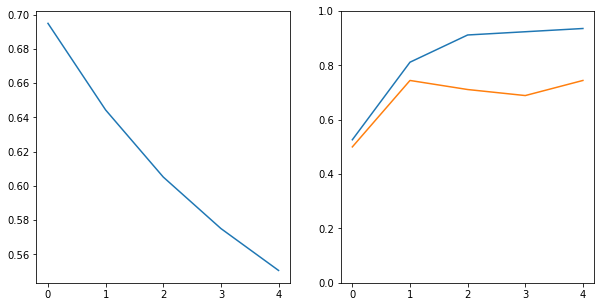

0it [00:00, ?it/s]

Epoch 5 of 60 took 63.574s
  training loss (in-iteration): 	0.550645
  training AUC: 			93.56 %
  validation AUC: 			74.44 %


7it [00:18,  2.62s/it]

KeyboardInterrupt: 

In [38]:
# D = 0.3
problem = "E/no E"
problem_label = "E"
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.3
learning_rate = 1e-4
weight_decay = 0
batch_size = 3
num_epochs = 60

problem_name = "voxcnn_mprage_8x2-16x2-32x3-64x3-BN-128-BN-D({})-64".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    model, opt = build_model(learning_rate, dropout, weight_decay)
    k = 0
    mean_train_auc, mean_val_auc, last_val_probs = train_model(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-1, vis_img_idx=train_idx[k], vis_layers=[])
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_auc_l, problem_name + "_train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name + "_val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name + "_val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [39]:
problem = "E/no E"
problem_label = "E"
dropout = 0.3
problem_name = "voxcnn_mprage_8x2-16x2-32x3-64x3-BN-128-BN-D({})-64".format(dropout)

train_auc_l = load_res(problem_name + "_train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "_val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "_val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
test_auc

('test auc mean:', 0.6762962962962963)
('test auc std:', 0.06314407502884406)


[0.6666666666666666,
 0.6777777777777778,
 0.7037037037037037,
 0.763888888888889,
 0.5694444444444444]

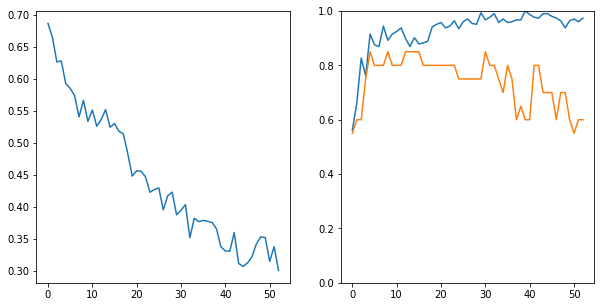

0it [00:00, ?it/s]

Epoch 53 of 60 took 38.405s
  training loss (in-iteration): 	0.300259
  training AUC: 			97.39 %
  validation AUC: 			60.00 %


8it [00:24,  3.10s/it]

KeyboardInterrupt: 

In [35]:
# D = 0.5
problem = "E/C"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.5
learning_rate = 1e-4
weight_decay = 0
batch_size = 3
num_epochs = 60

problem_name = "voxcnn_mprage_8x2-16x2-32x3-64x3-BN-128-BN-D({})-64".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    model, opt = build_model(learning_rate, dropout, weight_decay)
    k = 0
    mean_train_auc, mean_val_auc, last_val_probs = train_model(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-1, vis_img_idx=train_idx[k], vis_layers=[])
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_auc_l, problem_name + "_train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name + "_val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name + "_val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [35]:
problem = "E/C"
problem_label = "E"
dropout = 0.5
problem_name = "voxcnn_mprage_8x3-16x3-32x2-64x2-BN-128-BN-D({})-64".format(dropout)

train_auc_l = load_res(problem_name + "_train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "_val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "_val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
test_auc

('test auc mean:', 0.7375)
('test auc std:', 0.05448623679425842)


[0.8, 0.75, 0.65, 0.75]

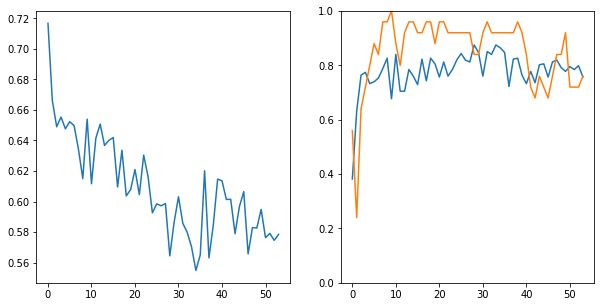

0it [00:00, ?it/s]

Epoch 54 of 60 took 22.013s
  training loss (in-iteration): 	0.578452
  training AUC: 			75.69 %
  validation AUC: 			76.00 %


7it [00:21,  3.11s/it]

KeyboardInterrupt: 

In [36]:
# D = 0.7
problem = "E/C"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.7
learning_rate = 1e-4
weight_decay = 0
batch_size = 3
num_epochs = 60

problem_name = "voxcnn_mprage_8x2-16x2-32x3-64x3-BN-128-BN-D({})-64".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    model, opt = build_model(learning_rate, dropout, weight_decay)
    k = 0
    mean_train_auc, mean_val_auc, last_val_probs = train_model(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-1, vis_img_idx=train_idx[k], vis_layers=[])
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_auc_l, problem_name + "_train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name + "_val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name + "_val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [36]:
len(test_auc)

12

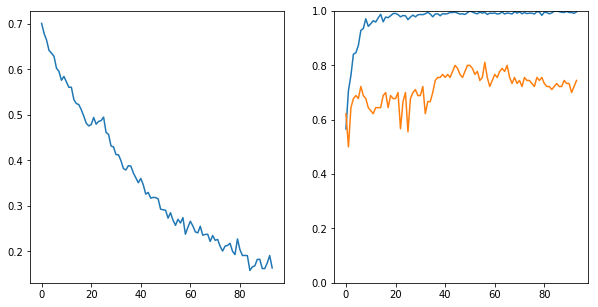

0it [00:00, ?it/s]

Epoch 94 of 150 took 77.051s
  training loss (in-iteration): 	0.163417
  training AUC: 			99.68 %
  validation AUC: 			74.44 %


2it [00:05,  2.89s/it]


KeyboardInterrupt: 

In [38]:
# D = 0.5
problem = "E/no E"
problem_label = "E"
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.5
learning_rate = 3e-5
weight_decay = 0
batch_size = 3
num_epochs = 150

problem_name = "voxcnn_mprage_8x2-16x2-32x3-64x3-BN-128-BN-D({})-64".format(dropout)

for i in range(len(test_auc), len(cv_splits[:10])):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    model, opt = build_model(learning_rate, dropout, weight_decay)
    k = 0
    mean_train_auc, mean_val_auc, last_val_probs = train_model(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-1, vis_img_idx=train_idx[k], vis_layers=[])
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_auc_l, problem_name + "_train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name + "_val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name + "_val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

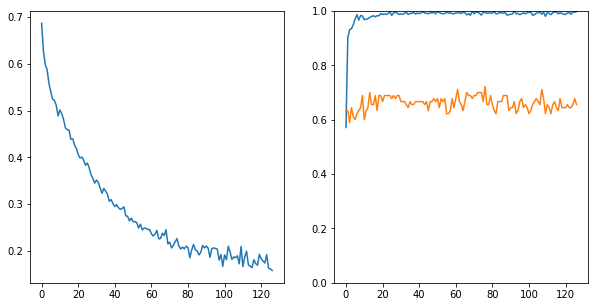

0it [00:00, ?it/s]

Epoch 127 of 400 took 43.524s
  training loss (in-iteration): 	0.157879
  training AUC: 			99.76 %
  validation AUC: 			65.56 %


5it [00:08,  1.74s/it]


KeyboardInterrupt: 

In [35]:
# D = 0.3
problem = "E/no E"
problem_label = "E"
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.3
learning_rate = 3e-5
weight_decay = 0
batch_size = 3

problem_name = "voxcnn_mprage_8x2-16x2-32x3-64x3-BN-128-BN-D({})-64".format(dropout)

for tr_idx, te_idx in cv_splits:
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    model, opt = build_model(learning_rate, dropout, weight_decay)
    k = 0
    mean_train_auc, mean_val_auc, last_val_probs = train_model(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=400, epsilon=1e-1, vis_img_idx=train_idx[k], vis_layers=[])
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(val_auc_l[-1])

    save_res(train_auc_l, problem_name + "_train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name + "_val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name + "_val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))